# AFL Model - Part 3 - Modelling

These tutorials will walk you through how to construct your own basic AFL model, using publically available data. The output will be odds for each team to win, which will be shown on [The Hub](https://www.betfair.com.au/hub/tools/models/afl-prediction-model/).

In this notebook we will walk you through modelling our AFL data to create predictions. We will train a variety of quick and easy models to get a feel of what works and what doesn't. We will then tune our hyperparameters so that we are ready to make week by week predictions.

## Grabbing Our Dataset
First, we will import our required modules, as well as the prepare_afl_features function which we created in our afl_feature_creation script. This essentially creates some basic features for us so that we can get started on the modelling component.

In [91]:
# Import libraries
from afl_feature_creation import prepare_afl_features
import afl_feature_creation
import afl_data_cleaning
import datetime
import pandas as pd
import numpy as np
from afl_data_cleaning import prepare_afl_data
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.feature_selection import RFECV
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn import feature_selection
from sklearn import metrics
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')

In [92]:
# Grab our feature DataFrame which we created in the previous tutorial
feature_df = afl_feature_creation.prepare_afl_features(window=6, k_factor=24)

First we will need to get our data onto individual rows for each game, rather than split on two rows like it is currently. We will create a function to do this merging for us, and then another function which subtracts the away stats from the home stats, so we reduce the amount of columns that we have.

In [93]:
def get_df_on_one_line(df):
    cols_to_drop = ['Team', 'Date', 'home_team', 'away_team', 'Home?', 'Opposition', 'Opposition Behinds', 'Opposition Goals', 
    'Opposition Points', 'Points', 'Round', 'Venue', 'Season', 'Status']
    
    # Create a home and away team DataFrame to then allow us to put each game onto individual rows
    home_df = df[df['Home?'] == 1]
    away_df = df[df['Home?'] == 0]
    away_df = away_df.drop(columns=cols_to_drop)
    home_df = home_df.drop(columns=['Team', 'Home?'])

    # Rename away_df columns
    away_df_renamed = away_df.rename(columns={col: col + '_away' for col in away_df.columns if col != 'Game'})
    merged_df = pd.merge(home_df, away_df_renamed, on='Game')
    return merged_df

In [94]:
# Use our function
afl_with_NaNs = get_df_on_one_line(feature_df)

# Drop NA rows which were a result of calculating rolling averages
afl = afl_with_NaNs.dropna().sort_values(by='Game')

# Drop columns which leak data and which we don't need
dropped_cols = ['Behinds', 'Goals', 'Opposition Behinds', 'Opposition Goals', 'Opposition Points', 'Points',
               'Behinds_away', 'Goals_away', 'home_win_away', 'home_elo_away', 'away_elo_away', 'elo', 'elo_Opp', 'CCL_ave_6', 
                'SCL_ave_6', 'SI_ave_6', 'MG_ave_6', 'TO_ave_6', 'ITC_ave_6', 'T5_ave_6', 'CCL_ave_6_away', 'SCL_ave_6_away',
               'SI_ave_6_away', 'MG_ave_6_away', 'TO_ave_6_away', 'ITC_ave_6_away', 'T5_ave_6_away', 'elo_away', 'elo_Opp_away']
afl = afl.drop(columns=dropped_cols)
afl = afl.drop_duplicates(keep='first')

Next, let's create a 'differential DataFrame' which essentially just subtracts the away teams' features from the home teams'. This will reduce the huge amount of columns we have and make our data more manageable. To do this, we will need a list of columns which we are subtracting from each other. We will then loop over each of these columns to create our new differential columns.

In [95]:
# Create a list of columns which we are subtracting from each other
cols = [col for col in afl.columns if col + '_away' in afl.columns and col != 'odds']

diff_df = afl.copy()
diff_cols = [col + '_diff' for col in cols]

for col in cols:
    diff_df[col + '_diff'] = afl[col] - afl[col + '_away']
    diff_df = diff_df.drop(columns=[col, col + '_away'])

Now let's create an implied odds feature from the odds. Some Machine Learning algorithms perform better if the features used are normally distributed, so we will try and normalise our odds slightly by finding the implied probability.

In [96]:
# Create an implied odds feature
diff_df['implied_odds_prob'] = 1 / diff_df['odds']
diff_df['implied_odds_prob_away'] = 1 / diff_df['odds']

## Creating a Training and Testing Set
So that we don't train our data on the data that we will later test our model on, we will create separate train and test sets. For this exercise we will use the 2018 season to test how our model performs, whilst the rest of the data can be used to train the model.

In [97]:
# Create our test and train sets from our afl DataFrame; drop the columns which leak the result, duplicates, and the advanced
# stats which don't have data until 2015

# Create our test set
test_x = diff_df[diff_df['Season'] == 2018].drop(columns=['home_win', 'odds', 'odds_away']).select_dtypes(include=[np.number])
test_y = diff_df[diff_df['Season'] == 2018]['home_win']

# Create our train sets
X = diff_df[diff_df['Season'] != 2018].drop(columns=['home_win', 'odds', 'odds_away']).select_dtypes(include=[np.number])
y = diff_df[diff_df['Season'] != 2018]['home_win']

## Using Cross Validation to Find The Best Algorithms
Now that we have our training set, we can run through a list of popular classifiers to determine which classifier is best for modelling our data. To do this we will create a function which uses Kfold cross-validation to find the 'best' algorithms, based on how accurate the algorithms' predictions are.

This function will take in a list of classifiers, which we will define below, as well as the training set and it's outcome, and output a DataFrame with the mean and std of the accuracy of each algorithm. Let's jump into it!

In [98]:
# Create a list of standard classifiers
classifiers = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
]

# Define a functiom which finds the best algorithms for our modelling task
def find_best_algorithms(classifier_list, X, y):
    # This function is adapted from https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
    # Cross validate model with Kfold stratified cross validation
    kfold = StratifiedKFold(n_splits=5)
    
    # Grab the cross validation scores for each algorithm
    cv_results = [cross_val_score(classifier, X, y, scoring = "accuracy", cv = kfold) for classifier in classifier_list]
    cv_means = [cv_result.mean() for cv_result in cv_results]
    cv_std = [cv_result.std() for cv_result in cv_results]
    algorithm_names = [alg.__class__.__name__ for alg in classifiers]
    
    # Create a DataFrame of all the CV results
    cv_results = pd.DataFrame({
        "Mean Accuracy": cv_means,
        "Accuracy Std": cv_std,
        "Algorithm": algorithm_names
    })
    
    
    # Create a plot showing the best cross_validation scores
    g = sns.barplot("Mean Accuracy", "Algorithm", data = cv_results.sort_values(by='Mean Accuracy'), palette="Set3", orient = "h", **{'xerr': cv_std})
    g.set_xlabel("Mean Accuracy")
    g = g.set_title("Cross Validation Scores")
    return cv_results

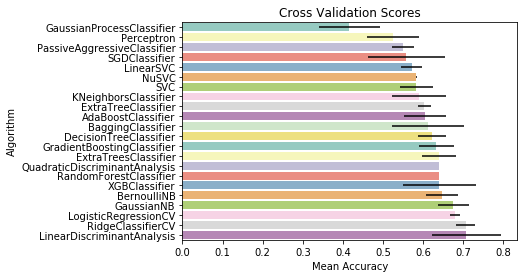

In [99]:
best_algos = find_best_algorithms(classifiers, X, y)

### Choosing Our Algorithms
As we can see from above, there are some pretty poor algorithms for predicting the winner. On the other hand, whilst attaining an accuracy of 70% may seem like a decent result; we must first establish a baseline to judge our performance on. In this case, we will have two baselines; the proportion of games won by the home team and what the odds predict. If we can beat the odds we have created a very powerful model.

Once we establish our baseline, we will choose the top algorithms from above and tune their hyperparameters, as well as automatically selecting the best features to be used in our model.

## Defining Our Baseline
As stated above, we must define our baseline so that we have a measure to beat. We will use the proportion of games won by the home team, as well as the proportion of favourites who won, based off the odds. To establish this baseline we will use our feature_df, as this has no dropped rows.

In [100]:
# Find the percentage chance of winning at home in each season.
afl_data = prepare_afl_data()
afl_data['home_win'] = afl_data.apply(lambda x: 1 if x['Margin'] > 0 else 0, axis=1)
home_games = afl_data[afl_data['Home?'] == 1]
home_games[["home_win", 'Season']].groupby(['Season']).mean()

,home_win
Season,
2011,0.566327
2012,0.567568
2013,0.570652
2014,0.580488
2015,0.548544
2016,0.619565
2017,0.608040
2018,0.561983


In [101]:
# Find the proportion of favourites who have won

# Define a function which finds if the odds correctly guessed the response
def find_odds_prediction(a_row):
    if a_row['odds'] <= a_row['odds_away'] and a_row['home_win'] == 1:
        return 1
    elif a_row['odds_away'] < a_row['odds'] and a_row['home_win'] == 0:
        return 1
    else:
        return 0

afl_data_one_line = get_df_on_one_line(afl_data)
afl_data_one_line['odds_prediction'] = afl_data_one_line.apply(find_odds_prediction, axis=1)
print('The overall mean accuracy of choosing the favourite based on the odds is {}%'.format(
    round(afl_data_one_line['odds_prediction'].mean() * 100, 2)))
afl_data_one_line[["odds_prediction", 'Season']].groupby(['Season']).mean()

The overall mean accuracy of choosing the favourite based on the odds is 71.42%


,odds_prediction
Season,
2011,0.780612
2012,0.745946
2013,0.706522
2014,0.717073
2015,0.718447
2016,0.690217
2017,0.648241
2018,0.704698


We can see that the odds are MUCH more accurate than just choosing the home team to win. We can also see that the mean accuracy of choosing the favourite is around 72%. That means that this is the score we need to beat. So let's choose all the algorithms which get a better score than 65% to tune.

In [102]:
chosen_algorithms = best_algos[best_algos['Mean Accuracy'] > 0.65]['Algorithm'].tolist()
best_algos[best_algos['Mean Accuracy'] > 0.65]

,Accuracy Std,Algorithm,Mean Accuracy
6,0.040423,LogisticRegressionCV,0.679317
8,0.016388,RidgeClassifierCV,0.706386
12,0.043408,GaussianNB,0.675689
19,0.012530,LinearDiscriminantAnalysis,0.708196


## Using Grid Search To Tune Hyperparameters
Now that we have our best models, we can use [Grid Search](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search) to optimise our hyperparameters. Grid search basically involves searching through a range of different algorithm hyperparameters, and choosing those which result in the best score from some metrics, which in our case is accuracy. Let's do this for the algorithms which have hyperparameters which can be tuned. Note that if you are running this on your own computer it may take up to 10 minutes.

In [103]:
# Define a function which optimises the hyperparameters of our chosen algorithms
def optimise_hyperparameters(train_x, train_y, algorithms, parameters):
    kfold = StratifiedKFold(n_splits=5)
    best_estimators = []
    
    for alg, params in zip(algorithms, parameters):
        gs = GridSearchCV(alg, param_grid=params, cv=kfold)
        gs.fit(train_x, train_y)
        best_estimators.append(gs.best_estimator_)
    return best_estimators

# Define our parameters to run a grid search over
lr_grid = {
    "C": [0.05, 0.2, 0.5, 0.75, 0.85, 1, 1.1, 1.2, 2],
    "solver": ["newton-cg", "lbfgs", "liblinear"]
}

ridge_grid = {'alpha': [1.0, 2.5, 5.0, 10.0]}

rf_grid = {
    "max_depth": [10, 15],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 20],
    "max_features": ["sqrt", "log2"]
}

# Add our algorithms and parameters to lists to be used in our function
alg_list = [LogisticRegression(), RidgeClassifier(), RandomForestClassifier(n_estimators=750, random_state=5, n_jobs=-1)]
param_list = [lr_grid, ridge_grid, rf_grid]

In [104]:
# Find the best estimators, then add our other estimators which don't need optimisation
best_estimators = optimise_hyperparameters(X, y, alg_list, param_list)
all_estimators = best_estimators + [GaussianNB(), LinearDiscriminantAnalysis()]

We now have a list of all the estimators we are going to use, with optimised hyperparameters. Our next step is to choose our features, and then we will create a stacked model using the estimators we just chose.

## Using Recursive Feature Elimination with Cross Validation to Select Features
Now that we have our model's hyperparameters tuned, we can focus on feature selection. Here, we will use Recursive Feature Elimination Cross Validation, which trains a specified model using cross-validation and recursively eliminates features until the model doesn't improve. We will use a Random Forest Classifier for this.

In [105]:
def select_features(X, y, estimator):
    # Remove non-numeric columns
    X = X.select_dtypes([np.number])
    
    clf = estimator
    selector = RFECV(clf, cv=10, scoring='accuracy')
    selector.fit(X, y)
    
    best_columns = list(X.columns[selector.support_])
    return best_columns

best_cols = select_features(X.drop(columns=['Game', 'Round', 'Season']), y, RandomForestClassifier(random_state=5))

Great! now we have tuned our model and chosen our features. Let's have a look at the features that we will be using.

In [106]:
best_cols

['home_elo',
 'away_elo',
 'GA_ave_6_diff',
 'CP_ave_6_diff',
 'UP_ave_6_diff',
 'ED_ave_6_diff',
 'CM_ave_6_diff',
 'MI5_ave_6_diff',
 'One.Percenters_ave_6_diff',
 'BO_ave_6_diff',
 'HB_ave_6_diff',
 'M_ave_6_diff',
 'G_ave_6_diff',
 'T_ave_6_diff',
 'HO_ave_6_diff',
 'I50_ave_6_diff',
 'CL_ave_6_diff',
 'CG_ave_6_diff',
 'R50_ave_6_diff',
 'FF_ave_6_diff',
 'FA_ave_6_diff',
 'AF_ave_6_diff',
 'SC_ave_6_diff',
 'disposal_efficiency_ave_6_diff',
 'R50_efficiency_ave_6_diff',
 'I50_efficiency_ave_6_diff',
 'Adj_elo_ave_margin_ave_6_diff',
 'average_elo_opponents_beaten_6_diff',
 'average_elo_opponents_lost_6_diff',
 'Margin_ave_6_diff',
 'implied_odds_prob',
 'implied_odds_prob_away']

## Stacking Our Models To Create A Strong Learner
A popular way to improve the accuracy of our individual models is to combine them together to create a strong learner. We are going to implement Stacking, which is an ensemble method which introduces the concept of a 'meta-learner'. Essentially, we use half of our training data to train a number of different classifiers, known as base-learners. In our case, these classifiers will be the ones which had an accuracy of 65% or greater. We then use these trained classifiers to predict the values of the other half of our training data. These predictions are known as base-predictions. We then use these predictions as the training data for a final classifier (we will use XGB), which we call a 'meta-leaner'.

To predict our final results all we need to do is feed our test data to the base learners which result in base-predictions, which we then feed to our meta-learner to predict our test labels.

I hope you got your head around that! Below is a diagram, taken from [this](http://supunsetunga.blogspot.com/2016/06/stacking-in-machine-learning.html?_sm_au_=iVVQP1LFpFrpsRqj) blog which depicts the process nicely.

![caption](Images/Stacking.png)

Let's now define a function which creates this strong learner.

In [107]:
def implement_xgb_stacking(train_x, train_y, test_x, classifier_list):
    # Get half of the DataFrame to train the base learners on and the other half to create base predictions
    xtrain_base, xpred_base, ytrain_base, ypred_base = train_test_split(train_x, train_y, test_size=0.5, random_state=42)
    
    # Create two DataFrames - one for our base predictions to train the meta-learner and the other to be used 
    # for the meta-learner's predictions
    base_df = pd.DataFrame()
    test_base_df = pd.DataFrame()
    
    # Loop over the classifiers to train the base-learners
    for clf in classifier_list:
        # Fit each classifier using the base training data
        clf.fit(xtrain_base, ytrain_base)
        
        # Create a base predictions DataFrame to be used to train the meta-learner
        base_preds = clf.predict(xpred_base)
        base_df[clf.__class__.__name__] = base_preds
        
        # Use the base learners to create test_predictions to be used for our final meta-learner predictions
        test_preds = clf.predict(test_x)
        test_base_df[clf.__class__.__name__] = test_preds

    meta_clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.25, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
    
    # Train the meta-learner
    meta_clf.fit(base_df, ypred_base)
    
    # Predict
    final_preds = meta_clf.predict(test_base_df)
    return final_preds

## Testing Our Model On the Test Set
Finally, we are ready to test our model on the test set, to see how accurate it was. Remember, the test set in this case is the 2018 season. The goal is to predict more footy games correctly than just choosing the favourite (which had an accuracy of 72% so far in 2018).

In [108]:
final_predictions = implement_xgb_stacking(X[best_cols], y, test_x[best_cols], all_estimators)

In [109]:
accuracy = (final_predictions == test_y).mean() * 100

print("Our accuracy in predicting the 2018 season is: {}%".format(accuracy))

Our accuracy in predicting the 2018 season is: 71.02803738317756%


Fantastic! We have predicted more results correctly than the odds. Let's now inspect our errors to see the games which we got wrong.

In [110]:
preds_index = test_x.index[(final_predictions != test_y)]
afl.loc[preds_index][['home_team', 'away_team', 'odds', 'odds_away', 'home_win', 'home_elo', 'away_elo']]

,home_team,away_team,odds,odds_away,home_win,home_elo,away_elo
1360,Essendon,Adelaide,1.8628,2.1393,1,1467.506321,1646.687609
1364,Gold Coast,North Melbourne,2.0161,1.9784,1,1300.806887,1410.870164
1365,Melbourne,Geelong,1.7737,2.2755,0,1454.806809,1703.083537
1367,Adelaide,Richmond,1.8478,2.1784,1,1628.994882,1567.420082
1368,North Melbourne,St Kilda,3.5769,1.3867,1,1395.190972,1466.363057
1369,Carlton,Gold Coast,1.5992,2.6620,0,1327.788050,1316.486079
1372,Fremantle,Essendon,2.6997,1.5939,1,1425.806319,1485.199049
1373,Western Bulldogs,West Coast,1.8044,2.2445,0,1499.579121,1555.297772
1374,Sydney,Port Adelaide,1.4949,3.0060,0,1678.762837,1556.637984
1375,Geelong,Hawthorn,1.7597,2.3024,0,1707.720913,1620.201973


Very interesting! Most of the games we got wrong were upsets. The model also seems to be picking against Richmond frequently against high quality teams like Adelaide and Geelong - despite Richmond being favourites and winning the 2017 premiership. This is most likely due to Richmond's low elo, and perhaps their game style resulting in less 'favourable' statistics according to our model. This is something we can improve upon in further iterations.

## Next Steps
Now that we have a model up and running, the next steps are to implement the model on a week to week basis. In the next tutorial we will be predicting the upcoming round of footy.